This notebook analyzes the activity of freezing cells (those active during or before/after freezing epochs) across days and in response to ANI administration

In [1]:
# Import useful modules
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [13]:
str(eraser_path)

'/Users/nkinsky/Documents/BU/GitHub/Eraser'

In [15]:
# Import project specific modules and enable automatic reloading
import sys
from pathlib import Path
import os
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))
%load_ext autoreload
%autoreload 2

from session_directory import find_eraser_directory as get_dir
import er_plot_functions as erp
import Placefields as pf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


For starters, look at one mouse and map velocity over calcium activity.

In [32]:
from glob import glob
from os import path
glob(str(Path(str(dir_use)) / 'FreezeFrame/*Index*.csv'))
# sorted((Path(str(dir_use)) / 'FreezeFrame/').glob('*Index*.csv'))[0]

['/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble7/20180319_2_fcbox/FreezeFrame/20180319_1_exposure_marble_7_Index.csv']

In [34]:
# Load in neural data and freezing data
mouse, arena, day = 'Marble07', 'Shock', -2
dir_use = erp.get_dir(mouse, arena, day)
PF = pf.load_pf(mouse, arena, day)

video_t = erp.get_timestamps(str(dir_use))
freezing, velocity = erp.detect_freezing(str(dir_use), arena=arena)
video_t = video_t[:-1]  # Chop off last timepoint to make this the same length as freezing and velocity arrays

# Now get time for imaging
t_imaging = np.arange(0, PF.PSAbool_align.shape[1])/PF.sr_image

/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble7/20180319_2_fcbox: nbadpts = 2 max_in_a_row = 1


Visualization: plot neral activity with velocity and freezing overlaid

<IPython.core.display.Javascript object>


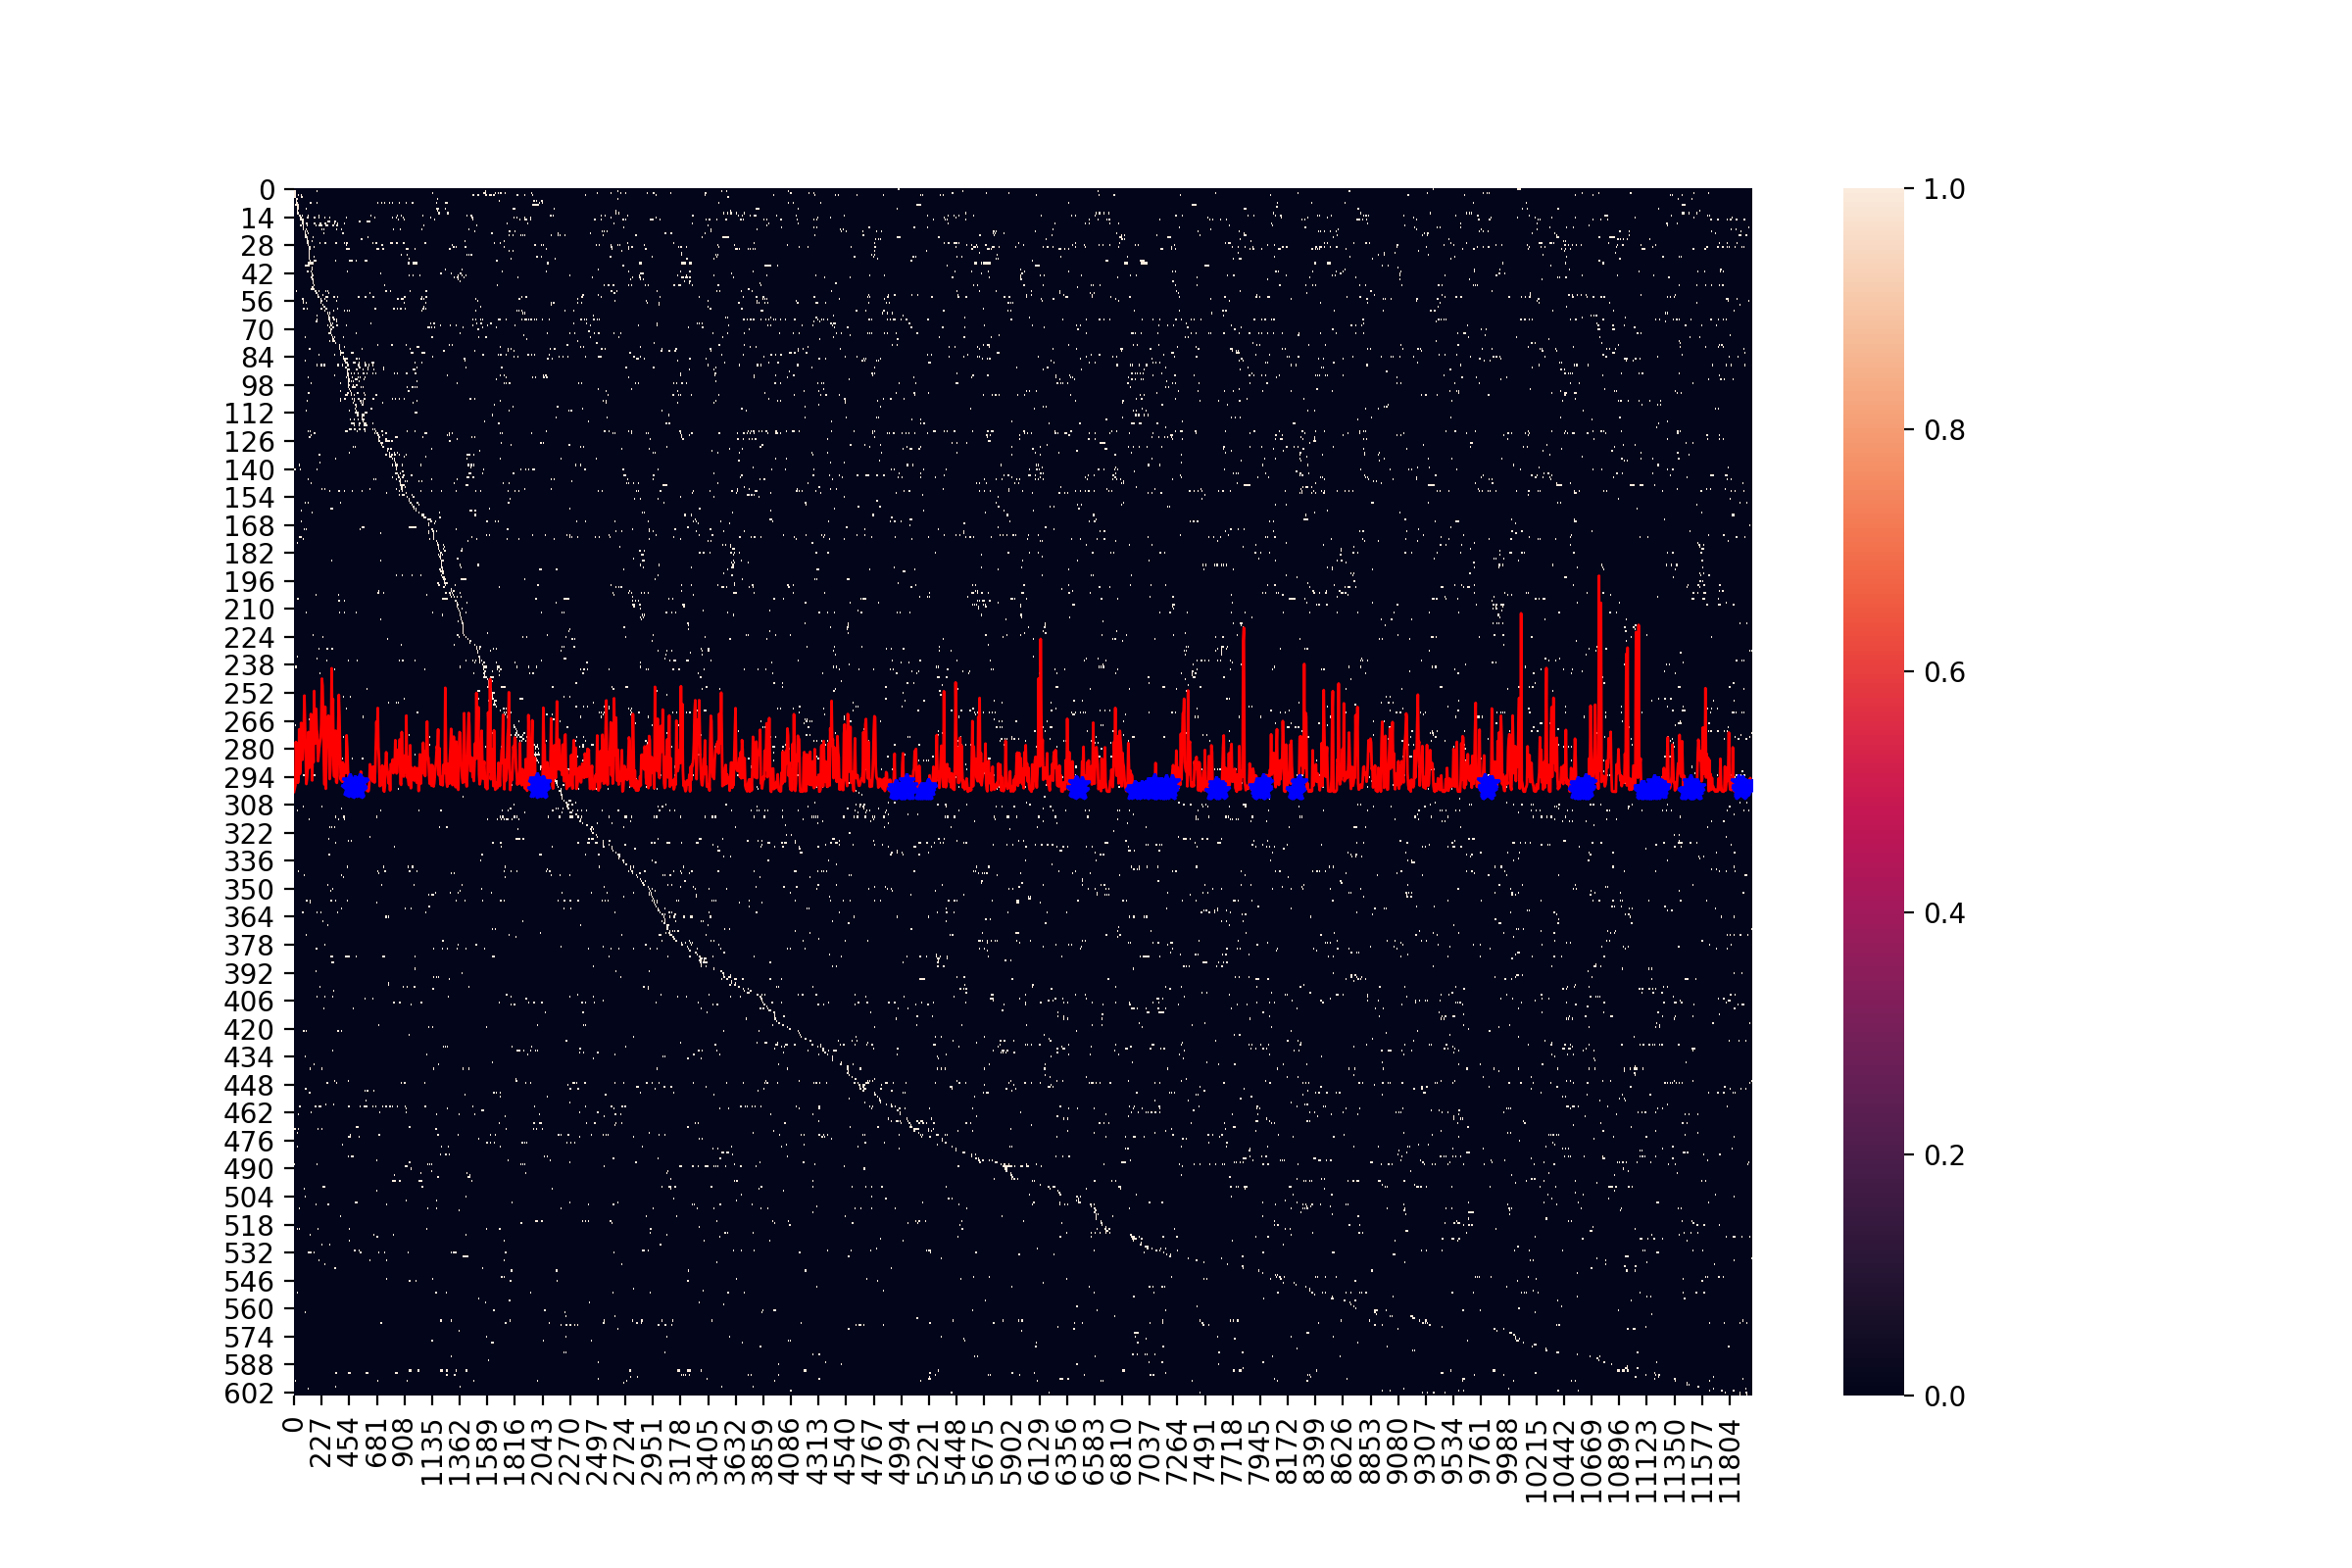

In [52]:
%matplotlib notebook
SFvel = 4  # Factor to scale velocity by for overlay below

fig, ax = plt.subplots()
fig.set_size_inches([12,8])
sns.heatmap(data=PF.PSAbool_align, ax=ax)
nneurons = PF.PSAbool_align.shape[0]
ax.plot(video_t*PF.sr_image, velocity*-SFvel+nneurons/2, color='r', linewidth=1)
ax.plot(video_t[freezing]*PF.sr_image, velocity[freezing]*-SFvel+nneurons/2, 'b*')

Ok, now figure color the above calcium events by their event-rate during freezing and/or sort by event rate during freezing...

In [65]:
# First, align freezing epochs to neural data - write function!
nneurons, nframes = PF.PSAbool_align.shape

# def align_freezing_to_PSA()
freezing_epochs = erp.get_freezing_epochs(freezing)

# Make boolean to match neural data shape
freezingPSA = np.zeros(nframes, dtype='bool')
PSAtime = np.arange(0, nframes)

(11991,)